# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import plotly.express as px
import torch
from torch_geometric import seed_everything

import sys
sys.path.append("../../..")
from src.models import training_utils

data_folder = "../../../data/processed/graph_data_nohubs/merged_types/"
experiments_folder = "../../../data/experiments/design_space_merged_experiment/seed_0/"

seed_everything(0)

# Cargo splits hechos con random link split

In [216]:
node_csv = pd.read_csv(data_folder+"merged_nodes.csv", index_col="node_index")
node_info = pd.read_csv(data_folder+"merged_node_info.csv",index_col=0)
edge_data = pd.read_csv(data_folder+"merged_edges.csv")

datasets, node_map = training_utils.load_data(data_folder+"split_dataset/seed_0/")
train_data,val_data = datasets

In [3]:
def get_tensor_index_df(node_data, node_map, node_info):
    sub_dfs = []
    for node_type in node_map.keys():
        sub_df = node_data[node_data.node_type == node_type]
        node_map_series = pd.Series(node_map[node_type], name="tensor_index")
        sub_df = sub_df.merge(node_map_series, left_on="node_index", right_index=True,
                              how="right").sort_values(by="tensor_index").reset_index()

        sub_dfs.append(sub_df)
    tensor_df = pd.concat(sub_dfs, ignore_index=True)
    df = pd.merge(tensor_df, node_info[["node_index", "comunidades_infomap", "comunidades_louvain",
                  "degree_gda", "degree_pp", "degree_dd"]], on="node_index")
    df["total_degree"] = df.degree_pp + df.degree_gda + df.degree_dd
    return df

def tensor_to_edgelist(tensor: torch.tensor):
    sources = tensor[0,:].tolist()
    targets = tensor[1,:].tolist()
    edgelist = list(zip(sources,targets))
    return edgelist

def reverse_map(node_map,edge_list,edge_type):
    """Maps edge dictionary from pyg Heterodata back into the original node indexes from the dataframe"""
    src_map = {v:k for k,v in node_map[edge_type[0]].items()}
    dst_map = {v:k for k,v in node_map[edge_type[2]].items()}
    mapped_edge_list = [(src_map[n1],dst_map[n2]) for (n1,n2) in edge_list]

    return mapped_edge_list

def inverse_map_heterodata(data,node_map):
    """Maps full edge data from pyg Heterodata back into the original node indexes from the dataframe"""
    edge_dict = {}
    for edge_type in data.edge_types:
        type_dict = {}
        edge_tensor = data[edge_type]["edge_index"]
        edge_list = tensor_to_edgelist(edge_tensor)
        mapped_edge_list = reverse_map(node_map,edge_list,edge_type)

        type_dict["message_passing_edges"] = mapped_edge_list

        if "edge_label_index" in data[edge_type].keys():
            labeled_edges_tensor = data[edge_type]["edge_label_index"]
            labeled_edges_list = tensor_to_edgelist(labeled_edges_tensor)
            mapped_labeled_edges_list = reverse_map(node_map,labeled_edges_list,edge_type)

            edge_labels = data[edge_type]["edge_label"].tolist()

            type_dict["supervision_edges"] = mapped_labeled_edges_list
            type_dict["supervision_labels"] = edge_labels
 
        edge_dict[edge_type] = type_dict
    
    return edge_dict

def edge_map_to_df(inverse_map_dict):
    edges_df = {}
    for edge_type,sub_dict in inverse_map_dict.items():
        if "supervision_edges" in sub_dict.keys():
            edges = pd.DataFrame(sub_dict["supervision_edges"]).rename(columns={0:edge_type[0],1:edge_type[2]})
            edge_labels_df = pd.concat([edges,pd.DataFrame(sub_dict["supervision_labels"])],axis=1).rename(columns={0:"label"})

            msg_passing_edges_df = pd.DataFrame(sub_dict["message_passing_edges"]).rename(columns={0:edge_type[0],1:edge_type[2]})

            edges_df[edge_type] = {"supervision_edges":edge_labels_df,"message_passing_edges":msg_passing_edges_df}
    
    return edges_df

def get_edge_df(data,node_map):
    inverse_map_dict = inverse_map_heterodata(data,node_map)
    df = edge_map_to_df(inverse_map_dict)
    return df

In [4]:
df = get_tensor_index_df(node_csv,node_map,node_info)
df

,node_index,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
0,0,1,A1BG,gene_protein,disgenet,0,NaN,NaN,2.0,12.0,0.0,14.0
1,653,10422,UBAC1,gene_protein,hippie,1,NaN,NaN,0.0,36.0,0.0,36.0
2,13168,63891,RNF123,gene_protein,disgenet,2,NaN,NaN,2.0,24.0,0.0,26.0
3,6638,284403,WDR62,gene_protein,disgenet,3,NaN,NaN,14.0,18.0,0.0,32.0
4,6611,284161,GDPD1,gene_protein,hippie,4,NaN,NaN,0.0,29.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35834,35265,R-HSA-5579013,Defective CYP7B1 causes SPG5A and CBAS3,pathway,primekg_REACTOME,2012,NaN,NaN,0.0,1.0,0.0,1.0
35835,35260,R-HSA-5579007,Defective ACY1 causes encephalopathy,pathway,primekg_REACTOME,2013,NaN,NaN,0.0,1.0,0.0,1.0
35836,35152,R-HSA-4687000,Defective MPDU1 causes MPDU1-CDG (CDG-1f),pathway,primekg_REACTOME,2014,NaN,NaN,0.0,1.0,0.0,1.0
35837,34551,R-HSA-1855231,Synthesis of IPs in the ER lumen,pathway,primekg_REACTOME,2015,NaN,NaN,0.0,1.0,0.0,1.0


# Proporción de samples negativas y positivas

Cuantas enfermedades aparecen en supervisión en total

In [5]:
mapped_dataset = inverse_map_heterodata(train_data,node_map)
df_dataset = edge_map_to_df(mapped_dataset)

supervision_edges = df_dataset[("gene_protein","gda","disease")]["supervision_edges"]
msg_edges = df_dataset[("gene_protein","gda","disease")]["message_passing_edges"]

Cuantas enfermedades aparecen en supervisión en total

In [6]:
# cuantas enf aparecen en supervisión
len(supervision_edges.disease.unique())

10794

Cuantas enfermedades aparecen en supervisión con samples positivas

In [7]:
len(supervision_edges[supervision_edges.label == 1].disease.unique())

3928

Cuantas enfermedades aparecen en supervisión con samples negativas

In [8]:
len(supervision_edges[supervision_edges.label == 0].disease.unique())

9117

# Frecuencia de sampleo positiva y negativa vs grado gda

Verifico que son los mismos enlaces

In [9]:
validation_edges = inverse_map_heterodata(val_data,node_map)
train_edges = inverse_map_heterodata(train_data,node_map)

edge_list = validation_edges[("gene_protein","gda","disease")]["message_passing_edges"]
gene_to_disease = [(b,a) for (a,b) in edge_list]
disease_to_gene = validation_edges[("disease","gda","gene_protein")]["message_passing_edges"]

len(set(gene_to_disease)&set(disease_to_gene)) == len(gene_to_disease)

True

In [10]:
import plotly.express as px
fig = px.histogram(supervision_edges[supervision_edges.label == 1].disease.value_counts(),width=800, height=400)
fig.show()

In [11]:
fig = px.histogram(supervision_edges[supervision_edges.label == 0].disease.value_counts(),width=800, height=400)
fig.show()

In [12]:
frec_negativa_disease = supervision_edges[supervision_edges.label==0].disease.value_counts()
frec_positiva_disease = supervision_edges[supervision_edges.label == 1].disease.value_counts()

frec_negativa_disease_df = pd.merge(frec_negativa_disease, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"disease":"frec_negativa"})

frec_positiva_disease_df = pd.merge(frec_positiva_disease, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"disease":"frec_positiva"})
frec_positiva_disease_df

,frec_positiva,degree_gda
18773,171,1074.0
20754,149,883.0
18978,113,702.0
19957,111,774.0
24165,108,616.0
...,...,...
33500,1,1.0
27115,1,7.0
23511,1,1.0
22899,1,4.0


In [13]:
fig = px.scatter(frec_negativa_disease_df,"frec_negativa","degree_gda",title="Frecuencia de sampleo negativa - Disease")
fig.show()

In [14]:
fig = px.scatter(frec_positiva_disease_df,"frec_positiva","degree_gda", title="Frecuencia de sampleo positiva - Disease")
fig.show()

In [15]:
frec_negativa_gene = supervision_edges[supervision_edges.label==0].gene_protein.value_counts()
frec_positiva_gene = supervision_edges[supervision_edges.label == 1].gene_protein.value_counts()

frec_negativa_gene_df = pd.merge(frec_negativa_gene, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"gene_protein":"frec_negativa"})

frec_positiva_gene_df = pd.merge(frec_positiva_gene, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"gene_protein":"frec_positiva"})
frec_positiva_gene_df

,frec_positiva,degree_gda
14290,63,340.0
13851,49,285.0
7855,42,231.0
7870,41,270.0
14201,37,179.0
...,...,...
8928,1,7.0
10622,1,7.0
17358,1,2.0
14493,1,5.0


In [16]:
fig = px.scatter(frec_negativa_gene_df,"frec_negativa","degree_gda",title="Frecuencia de sampleo negativa - Genes")
fig.show()

In [17]:
fig = px.scatter(frec_positiva_gene_df,"frec_positiva","degree_gda",title="Frecuencia de sampleo positiva - Genes")
fig.show()

# Para un dado nodo, como quedan los splits

In [18]:
node_info.sort_values(by="degree_gda",ascending=False)

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
17,18773,C0006142,Malignant neoplasm of breast,disease,disgenet,11.0,3.0,1074.0,0.0,7.0
8,20754,C0036341,Schizophrenia,disease,disgenet,0.0,0.0,883.0,0.0,1.0
71,19957,C0023893,"Liver Cirrhosis, Experimental",disease,disgenet,NaN,NaN,774.0,0.0,0.0
1178,18978,C0009402,Colorectal Carcinoma,disease,disgenet,624.0,3.0,702.0,0.0,5.0
16,24165,C0376358,Malignant neoplasm of prostate,disease,disgenet,3.0,2.0,616.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...
10439,36013,R-HSA-9615933,Postmitotic nuclear pore complex (NPC) reforma...,pathway,primekg_REACTOME,NaN,NaN,0.0,27.0,0.0
10438,16636,8498,RANB3,gene_protein,hippie,NaN,NaN,0.0,9.0,0.0
24618,6397,2738,GLI4,gene_protein,hippie,NaN,NaN,0.0,2.0,0.0
10436,13689,653489,RGPD3,gene_protein,hippie,NaN,NaN,0.0,4.0,0.0


In [19]:
node_index = 18773
dataset = val_data

mapped_dataset = inverse_map_heterodata(dataset,node_map)
df_dataset = edge_map_to_df(mapped_dataset)

supervision_edges = df_dataset[("gene_protein","gda","disease")]["supervision_edges"]
node_supervision_edges = supervision_edges[supervision_edges.disease == node_index]

msg_edges = df_dataset[("gene_protein","gda","disease")]["message_passing_edges"]
node_msg_edges = msg_edges[msg_edges.disease == node_index]

In [20]:
node_msg_edges

,gene_protein,disease
1250,5099,18773
1251,1,18773
1252,9418,18773
1253,12682,18773
1254,3,18773
...,...,...
2081,17807,18773
2082,18017,18773
2083,18067,18773
2084,18373,18773


In [21]:
node_supervision_edges.label.value_counts()

1.0    116
0.0      1
Name: label, dtype: int64

the horror

# Pruebo otros métodos de sampleo

Está la opción de no samplear de una para los 3 splits y hacer el sampleo para cada pasada de entrenamiento. Vamos a ver como queda eso

In [218]:
from torch_geometric.utils import negative_sampling, structured_negative_sampling
import torch_geometric.transforms as T

# Cargo el heterodata completo
path = data_folder + "split_dataset/seed_0/full_dataset.pt"
full_dataset = torch.load(path)

In [219]:
def get_reverse_types(edge_types):
    newlist = []
    for edge in edge_types:
        rev = tuple(reversed(edge))
        if rev != edge:
            if edge not in newlist:
                newlist.append(rev)
        else:
            newlist.append(rev)

    reversed_newlist = [tuple(reversed(edge)) for edge in newlist]

    return newlist, reversed_newlist

Hago un split ahora

In [220]:
edge_types, rev_edge_types = get_reverse_types(full_dataset.edge_types)
p_val = 0.1
p_test = 0.1
p_train = round(1 - p_val - p_test, 1)
disjoint_ratio = 0.2

split_transform = T.RandomLinkSplit(num_val=p_val, num_test=p_test, is_undirected=True, add_negative_train_samples=False,
                                    disjoint_train_ratio=disjoint_ratio, edge_types=edge_types, rev_edge_types=rev_edge_types)
transform_dataset = T.Compose(
    [split_transform, T.ToSparseTensor(remove_edge_index=False)])

train_data, val_data, test_data = transform_dataset(full_dataset)

## Negative sampling estandar

Ahora val y test tienen samples positivas y negativas, pero **train solo tiene samples positivas**

In [25]:
from torch_geometric.utils import negative_sampling, structured_negative_sampling

dataset = copy.copy(train_data)
edge_index = dataset["gene_protein","gda","disease"]["edge_index"]
edge_label = dataset["gene_protein","gda","disease"]["edge_label"]
edge_label_index = dataset["gene_protein","gda","disease"]["edge_label_index"]

num_samples = len(edge_label)
num_nodes = (dataset["gene_protein"]["num_nodes"],dataset["disease"]["num_nodes"])
negative_sample = negative_sampling(edge_index,num_nodes=num_nodes,num_neg_samples=num_samples)

In [26]:
new_label_index = torch.concat((edge_label_index,negative_sample),dim=1)
new_label = torch.concat((edge_label,torch.zeros_like(edge_label)))

dataset["gene_protein","gda","disease"]["edge_label_index"] = new_label_index
dataset["gene_protein","gda","disease"]["edge_label"] = new_label

new_df = get_edge_df(dataset,node_map)

In [27]:
supervision_edges = new_df["gene_protein","gda","disease"]["supervision_edges"]
frec_negativa = supervision_edges[supervision_edges.label==0].disease.value_counts()
frec_positiva = supervision_edges[supervision_edges.label == 1].disease.value_counts()

frec_negativa_df = pd.merge(frec_negativa, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"disease":"frec_negativa"})
frec_positiva_df = pd.merge(frec_positiva, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"disease":"frec_positiva"})


fig1 = px.scatter(frec_negativa_df,"frec_negativa","degree_gda")
fig2 = px.scatter(frec_positiva_df,"frec_positiva","degree_gda")

fig1.show()


## Structured negative sampling 
Genera un enlace negativo por cada enlace positivo

In [28]:
dataset = copy.copy(train_data)
edge_index = dataset["gene_protein","gda","disease"]["edge_index"]
edge_label = dataset["gene_protein","gda","disease"]["edge_label"]
edge_label_index = dataset["gene_protein","gda","disease"]["edge_label_index"]

num_samples = len(edge_label)
num_nodes = (dataset["gene_protein"]["num_nodes"],dataset["disease"]["num_nodes"])
negative_sample = structured_negative_sampling(edge_label_index,num_nodes[1],contains_neg_self_loops=False)
negative_sample_index = torch.stack((negative_sample[0],negative_sample[2]))

In [29]:
new_label_index = torch.concat((edge_label_index,negative_sample_index),dim=1)
new_label = torch.concat((edge_label,torch.zeros_like(edge_label)))

dataset["gene_protein","gda","disease"]["edge_label_index"] = new_label_index
dataset["gene_protein","gda","disease"]["edge_label"] = new_label

new_df = get_edge_df(dataset,node_map)

In [30]:
supervision_edges = new_df["gene_protein","gda","disease"]["supervision_edges"]
frec_negativa = supervision_edges[supervision_edges.label==0].disease.value_counts()
frec_positiva = supervision_edges[supervision_edges.label == 1].disease.value_counts()

frec_negativa_df = pd.merge(frec_negativa, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"disease":"frec_negativa"})
frec_positiva_df = pd.merge(frec_positiva, node_info[["degree_gda","node_index"]].set_index("node_index"),right_index=True,left_index=True,how="left").rename(columns={"disease":"frec_positiva"})

fig1 = px.scatter(frec_negativa_df,"frec_negativa","degree_gda")
fig2 = px.scatter(frec_positiva_df,"frec_positiva","degree_gda")

fig1.show()

es medio lo mismo no. Igual creo que estaría bueno usar este para que no haya leaks, osea, los positivos de train no van a ser los positivos de val, perturbando los de train evito que se solapen? ?? nose!? Tendría que ver esto

# Pruebo otras formas de samplear

## Distribución deg 0.75

In [244]:
class NegativeSampler:
    def __init__(self,full_dataset,edge_type,src_degrees,dst_degrees) -> None:
        src_type, _ , dst_type = edge_type
        self.num_nodes = (dataset[src_type]["num_nodes"],dataset[dst_type]["num_nodes"])

        full_positive_index = full_dataset.edge_index_dict[edge_type]
        self.full_positive_hash = self.index_to_hash(full_positive_index)

        self.weights = [src_degrees,dst_degrees]
    
    def index_to_hash(self,edge_index):
        size = self.num_nodes
        row, col = edge_index
        hashed_edges = (row * size[1]).add_(col)
        return hashed_edges

    def hash_to_index(self,hashed_edges):
        size = self.num_nodes
        row = hashed_edges.div(size[1], rounding_mode='floor')
        col = hashed_edges % size[1]
        return torch.stack([row, col], dim=0)
    
    def sample_negatives(self,num_samples,src_or_dst):
        """num_samples: number of samples generated, output will have shape [num_samples]. 
        src_or_dst: use src or dst weights to generate sample. 0:src weights, 1:dst weights
        """
        probs = torch.tensor(self.weights[src_or_dst]**0.75)
        neg_samples = probs.multinomial(num_samples, replacement=True)
        return neg_samples
    
    def generate_negative_edge_index(self,positive_edge_index,method):
        if method == "corrupt_both":
            num_samples = positive_edge_index.shape[1]
            new_src_index = self.sample_negatives(num_samples,0)
            new_dst_index = self.sample_negatives(num_samples,1)
            negative_edge_index = torch.stack([new_src_index,new_dst_index])
            return negative_edge_index
        elif method == "fix_src":
            src_index, _ = positive_edge_index
            new_dst_index = self.sample_negatives(src_index.numel(),1)
            negative_edge_index = torch.stack([src_index,new_dst_index])
            return negative_edge_index
        elif method == "fix_dst":
            _, dst_index = positive_edge_index
            new_src_index = self.sample_negatives(dst_index.numel(),0)
            negative_edge_index = torch.stack([new_src_index,dst_index])
            return negative_edge_index            
    
    def test_false_negatives(self,negative_edge_index,positive_edge_index):
        full_hash = self.full_positive_hash
        negative_hash = self.index_to_hash(negative_edge_index)
        positive_hash = self.index_to_hash(positive_edge_index)

        false_negatives_mask = torch.isin(negative_hash,full_hash)
        new_negative_hash = negative_hash[~false_negatives_mask]
        retry_positive_hash = positive_hash[false_negatives_mask]

        return new_negative_hash, retry_positive_hash
    
    def get_negative_sample(self,positive_edge_index,method):
        """positive_edge_index: edge_index with positive edges, this method will use positive_edge_index as a starting point to generate a negative index
        with the same shape as positive_edge_index.
        
        method: 
        corrupt_both: sample both src and dst nodes with probability deg**0.75
        fix_src: keep original src nodes and sample dst nodes with probability deg**0.75
        fix_dst: like fix_src but keep original dst nodes"""
        true_negatives = []
        retry_positive_hash = torch.tensor([0]) #placeholder
        temp_positive_edge_index = copy.copy(positive_edge_index)

        while retry_positive_hash.numel() > 0:
            negative_edge_index = self.generate_negative_edge_index(temp_positive_edge_index,method)
            true_neg_hash, retry_positive_hash = self.test_false_negatives(negative_edge_index,temp_positive_edge_index)

            true_negatives.append(true_neg_hash)
            temp_positive_edge_index = self.hash_to_index(retry_positive_hash)


        negative_edge_hash = torch.concat(true_negatives)
        negative_edge_index = self.hash_to_index(negative_edge_hash)

        return negative_edge_index
    
    def get_labeled_tensors(self,positive_edge_index,method):
        sample = self.get_negative_sample(positive_edge_index,method)
        edge_label_index = torch.concat([positive_edge_index,sample],dim=1)
        edge_label = torch.concat([torch.ones(positive_edge_index.shape[1]), torch.zeros(positive_edge_index.shape[1])])
        return edge_label_index, edge_label

In [234]:
path = data_folder +"split_dataset/seed_0/full_dataset.pt"
full_dataset = torch.load(path)

src_degrees = df[df.node_type == "gene_protein"]["degree_gda"].values
dst_degrees = df[df.node_type == "disease"]["degree_gda"].values
edge_type = ("gene_protein","gda","disease")
positive_edge_index = train_data.edge_label_index_dict[edge_type]

negative_sampler = NegativeSampler(full_dataset,("gene_protein","gda","disease"),src_degrees,dst_degrees)

Verifico frecuencia de falsos negativos (pasa si se solapan dos hash)

In [235]:
%%timeit
sample = negative_sampler.get_negative_sample(positive_edge_index,"corrupt_both")
true_neg,false_neg = negative_sampler.test_false_negatives(sample,positive_edge_index)

61.4 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


(array([  0.,   0.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

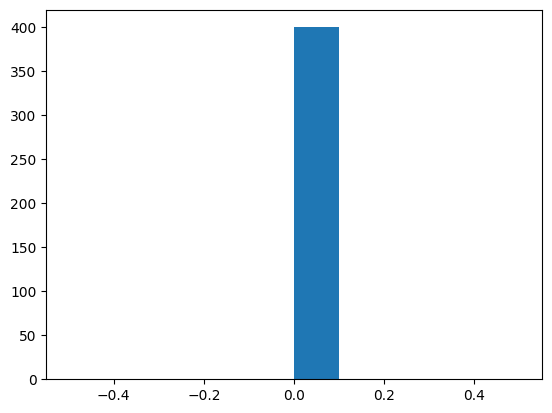

In [236]:
tries = 400
total = []
for _ in range(tries):
    sample = negative_sampler.get_negative_sample(positive_edge_index,"corrupt_both")
    true_neg,false_neg = negative_sampler.test_false_negatives(sample,positive_edge_index)
    total.append(false_neg.numel())

plt.hist(total)

In [237]:
sample = negative_sampler.get_negative_sample(positive_edge_index,"corrupt_both")

def plot_neg_frequency(sample,node_type,df=df):
    i = 0 if node_type == "gene_protein" else 1
    unique, counts = np.unique(sample[i].numpy(),return_counts=True)
    frec_negativa_df = pd.DataFrame([unique,counts]).T.rename(columns={0:"tensor_index",1:"frecuencia_negativa"})
    frec_negativa_df = frec_negativa_df.merge(df.loc[df.node_type == node_type,["tensor_index","degree_gda"]],left_on="tensor_index",right_on="tensor_index",how="left")
    frec_negativa_df.sort_values(by="frecuencia_negativa",ascending=False)

    fig = px.scatter(frec_negativa_df,"frecuencia_negativa","degree_gda",title=f"Frecuencia de sampleo negativa - {node_type}")
    fig.show()

plot_neg_frequency(sample,"gene_protein")
plot_neg_frequency(sample,"disease")

# Verificar que no genere leaks (mismo negativo en diferentes splits)

La probabilidad de generar leaks es muy baja, no creo que valga la pena resamplear por esto durante el entrenamiento.

In [173]:
val_labels = val_data[edge_type]["edge_label"]
val_labeled_edges = val_data[edge_type]["edge_label_index"]

index = torch.nonzero(val_labels == 0).flatten()
val_negative_edges = val_labeled_edges[:,index]

In [191]:
def test_leaks(negative_train_index, negative_val_index):
    train_hash = negative_sampler.index_to_hash(negative_train_index)
    val_hash = negative_sampler.index_to_hash(negative_val_index)

    leaked_negatives_mask = torch.isin(train_hash,val_hash)

    return leaked_negatives_mask

(array([2.29      , 0.        , 0.        , 0.85666667, 0.        ,
        0.        , 0.15666667, 0.        , 0.        , 0.03      ]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

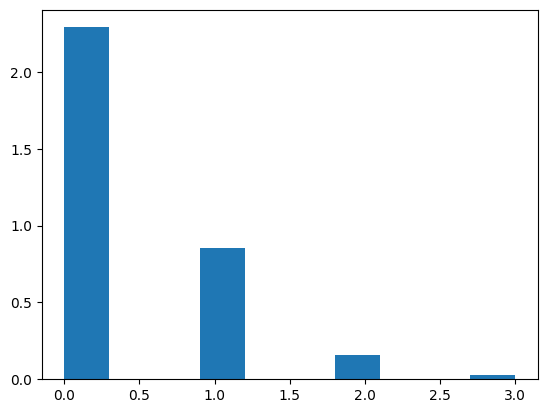

In [209]:
tries = 1000
total = []
for _ in range(tries):
    sample = negative_sampler.get_negative_sample(positive_edge_index,"corrupt_both")
    leaks = test_leaks(sample,val_negative_edges)
    total.append(leaks.sum())

plt.hist(np.array(total),density=True)

# Generar las muestras negativas para val y test? xq esa distribución tmb va a ser rara

- si

In [211]:
plot_neg_frequency(val_negative_edges,"gene_protein")
plot_neg_frequency(val_negative_edges,"disease")

# Poner el negative index generado y las labels en el heterodata correspondiente

In [245]:
new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(edge_index,"corrupt_both")

val_labels = val_data[edge_type]["edge_label"]
val_labeled_edges = val_data[edge_type]["edge_label_index"]

index = torch.nonzero(val_labels == 1).flatten()
val_positive_edges = val_labeled_edges[:,index]

new_val_label_index, new_val_label = negative_sampler.get_labeled_tensors(val_positive_edges,"corrupt_both") #ok it works

In [258]:
index = torch.nonzero(new_val_label == 0).flatten()
sample = new_val_label_index[:,index]
plot_neg_frequency(sample,"gene_protein")